In [13]:
import cv2
import mediapipe as mp
import numpy as np
import os
import csv
from datetime import datetime

wCam, hCam = 640, 480

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

cap = cv2.VideoCapture(0)
cap.set(3, wCam)
cap.set(4, hCam)

counter = 0
stage = None
index = 0
target_reps = 10 
current_hand = "left"

folderPath = "C:/Users/susmo/Downloads/images"
myList = os.listdir(folderPath)
print(myList)
overlayList = []
for imPath in myList:
    image = cv2.imread(f'{folderPath}/{imPath}')
    if image is not None:  
        overlayList.append(image)
    else:
        print(f"Failed to load image: {imPath}")

output_folder_path = "C:/Users/susmo/Downloads/saved_images"
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# CSV file setup
csv_filename = "reps_log.csv"
csv_path = os.path.join(output_folder_path, csv_filename)

with open(csv_path, mode='w', newline='') as csvfile:
    fieldnames = ['Timestamp', 'Session', 'Hand', 'Reps']
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()

    def log_reps(timestamp, session, hand, reps):
        csv_writer.writerow({'Timestamp': timestamp, 'Session': session, 'Hand': hand, 'Reps': reps})

    def calculate_angle(a, b, c):
        a = np.array(a)
        b = np.array(b)
        c = np.array(c)

        radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
        angle = np.abs(radians * 180.0/np.pi)
        angle = round(angle, 2)

        if angle > 180.0:
            angle = 360 - angle
        return angle

    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        while cap.isOpened():
            ret, frame = cap.read()

            if ret:
                if overlayList and index < len(overlayList):
                    h, w, c = overlayList[index].shape
                    # 398 + 242 (image width) = 640 (cap width size)
                    frame[0:h, 398:w+398] = overlayList[index]

                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                image.flags.writeable = False

                results = pose.process(image)
                image.flags.writeable = True
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

                try:
                    landmarks = results.pose_landmarks.landmark

                    if current_hand == "left":
                        shoulder = [landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].x,
                                    landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y]
                        elbow = [landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y]
                        wrist = [landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].x,
                                 landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y]
                    else:  
                        shoulder = [landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].x,
                                    landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y]
                        elbow = [landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].x,
                                 landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y]
                        wrist = [landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].x,
                                 landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y]

                    angle = calculate_angle(shoulder, elbow, wrist)

                    cv2.putText(image, f"{current_hand.capitalize()} Hand", (10, 30),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)

                    cv2.putText(image, f"Reps: {counter}", (10, 60),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2, cv2.LINE_AA)

                    if angle > 120:
                        stage = "down"
                        index = 0
                    if angle < 50 and stage == "down":
                        stage = "up"
                        index = 1
                        counter += 1
                        print(counter)

                        # Logging reps to CSV
                        log_reps(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), counter, current_hand, 1)

                        if counter >= target_reps:
                            print(f"Target repetitions ({target_reps}) reached for {current_hand} hand.")
                            counter = 0 
                            if current_hand == "left":
                                current_hand = "right"
                            else:
                                break 

                except Exception as e:
                    print(f"Error processing frame: {e}")

                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                          mp_drawing.DrawingSpec(color=(0, 0, 255), thickness=2, circle_radius=2),
                                          mp_drawing.DrawingSpec(color=(0, 128, 0), thickness=2, circle_radius=2))

                cv2.imshow('Integrate App', image)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break

# Release resources
cap.release()
cv2.destroyAllWindows()


['arm-down.jpg', 'arm-up.jpg']
1
2
3
4
5
6
7
8
9
10
Target repetitions (10) reached for left hand.
1
2
3
4
5
6
7
8
9
10
Target repetitions (10) reached for right hand.


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "C:/Users/susmo/Downloads/saved_images/reps_log.csv"
df = pd.read_csv(csv_path)
df.head()


,Timestamp,Session,Hand,Reps
0,2024-02-18 08:03:51,1,left,1
1,2024-02-18 08:03:54,2,left,1
2,2024-02-18 08:03:57,3,left,1
3,2024-02-18 08:03:59,4,left,1
4,2024-02-18 08:04:01,5,left,1


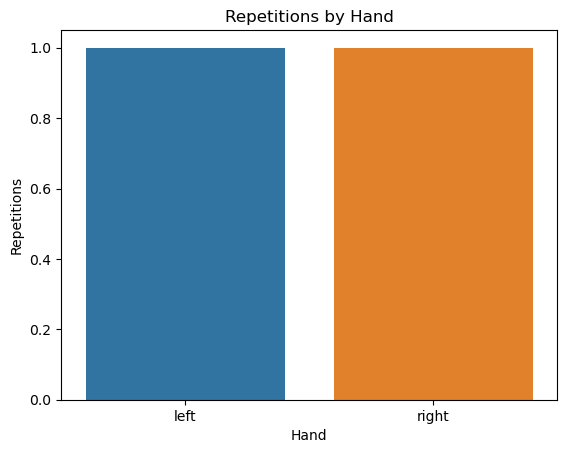

In [15]:
sns.barplot(x='Hand', y='Reps', data=df)
plt.title('Repetitions by Hand')
plt.xlabel('Hand')
plt.ylabel('Repetitions')
plt.show()


In [4]:
import pandas as pd

data_exercise = {
    'Activity': [
        'Finger Tapping', 'Toe Touches', 'Neck Rotation', 'Bicep Curls', 'Eye Tracking',
        'Full Body Stretch', 'Speech Articulation', 'Eye Blinking', 'Hand Squeezes',
        'Leg Lifts', 'Head Tilts', 'Shoulder Rolls', 'Ankle Circles', 'Jaw Exercises',
        'Wrist Flexion and Extension', 'Calf Raises', 'Neck Flexion and Extension', 'Knee Extensions',
        'Eye Focus Exercises', 'Arm Circles', 'Lunges', 'Facial Relaxation', 'Elbow Flexion and Extension',
        'Breathing Exercises',
        # Add more exercises as needed
    ],
    'Category': [
        'Hand Exercise', 'Leg Exercise', 'Head Exercise', 'Muscles Exercise', 'Eye Exercise',
        'Other Body Exercise', 'Speech Therapy', 'Eye Exercise', 'Hand Exercise',
        'Leg Exercise', 'Head Exercise', 'Shoulder Exercise', 'Leg Exercise', 'Speech Therapy',
        'Hand Exercise', 'Leg Exercise', 'Head Exercise', 'Leg Exercise', 'Eye Exercise',
        'Arm Exercise', 'Leg Exercise', 'Face Exercise', 'Arm Exercise', 'Breathing Exercise',
        # Add corresponding categories for each exercise
    ]
}

df_exercise = pd.DataFrame(data_exercise)

# Export to Excel
excel_path = "C:/Users/susmo/OneDrive/Desktop/Recomendation/exercise_recommendations.xlsx"
df_exercise.to_excel(excel_path, index=False)
print(f"Exercise data has been exported to {excel_path}")


Exercise data has been exported to C:/Users/susmo/OneDrive/Desktop/Recomendation/exercise_recommendations.xlsx


In [9]:
import pandas as pd

excel_path = "C:/Users/susmo/OneDrive/Desktop/Recomendation/exercise_recommendations.xlsx"
df_extension = pd.read_excel(excel_path)

user_preferences = input("Enter your preferences (comma-separated): ")
user_preferences = user_preferences.lower().split(', ')

df_extension['Category'] = df_extension['Category'].str.lower()

def recommend_therapy(user_preferences):
    matched_rows = df_extension[df_extension['Category'].apply(lambda x: any(pref in x for pref in user_preferences))]
    if not matched_rows.empty:
        return matched_rows['Activity'].tolist()
    else:
        return ["No matching therapy activity found."]

recommendations = recommend_therapy(user_preferences)

print("\nRecommended Therapy Activities:")
for activity in recommendations:
    print(activity)


Enter your preferences (comma-separated): head exercise

Recommended Therapy Activities:
Neck Rotation
Head Tilts
Neck Flexion and Extension
